<a href="https://colab.research.google.com/github/manansethia/IOAI/blob/main/notebooks/SGD-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Gradient Descent from Scratch

This notebook expands the upon the [*Gradient Descent from Scratch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/gradient-descent-from-scratch.ipynb) to introduce *stochastic* gradient descent (SGD).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)
np.random.seed(42)

### Simulate data

Create a vector tensor `x` with eight million points spaced evenly from zero to eight:

In [3]:
n = 8000000

In [4]:
x = torch.linspace(0., 8., n) # using typical 'x' convention for vector instead of 'xs'

Use the same line equation as in the [*Regression in PyTorch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb) to simulate eight million $y$ values for the vector `y`. That is, $m = -0.5$ and $b = 2$:
$$y = mx + b + \epsilon = -0.5x + 2 + \mathcal{N}(0, 1)$$

In [5]:
y = -0.5*x + 2 + torch.normal(mean=torch.zeros(n), std=1) # 'y' vector instead of 'ys'

Let's randomly sample a couple thousand points for the purpose of data visualization:

In [6]:
indices = np.random.choice(n, size=2000, replace=False)

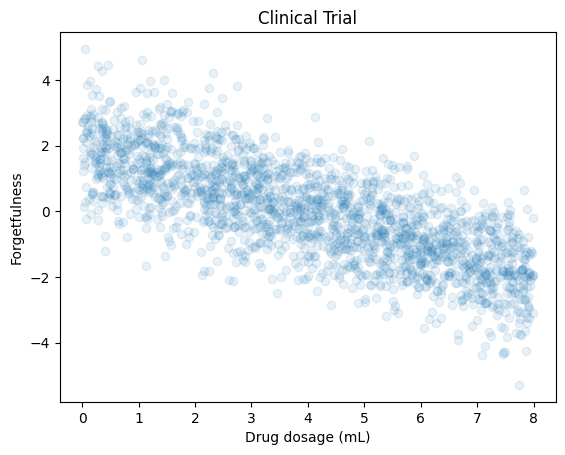

In [7]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x[indices], y[indices], alpha=0.1)

### Define model and "randomly" initialize model parameters

In [8]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [9]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

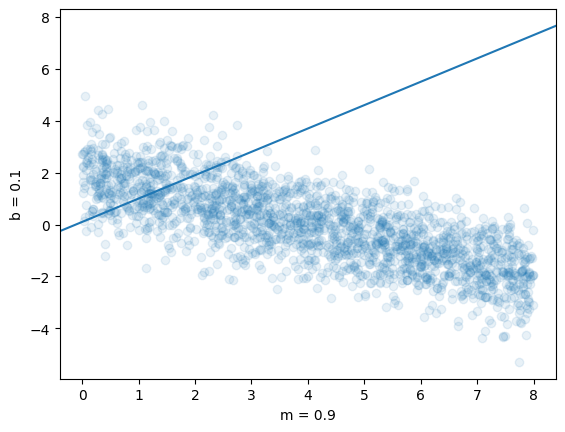

In [23]:
fig, ax = plt.subplots()

ax.scatter(x[indices], y[indices], alpha=0.1)

x_min, x_max = ax.get_xlim()
y_min = regression(x_min, m, b).detach().numpy() # detach() stops requiring grad on Tensor (required before conversion to plottable Numpy array)
y_max = regression(x_max, m, b).detach().numpy()

plt.ylabel('b = {}'.format('%.3g' % b.item()))
plt.xlabel('m = {}'.format('%.3g' % m.item()))

ax.set_xlim([x_min, x_max])
_ = ax.plot([x_min, x_max], [y_min, y_max], c = 'C10')

### Optimize parameters via SGD

Randomly (*stochastically*) sample a mini-batch of data for gradient descent:

In [24]:
batch_size = 32 # model hyperparameter

Sample without replacement. If you run out of data (which we won't in this example because we'll do 100 rounds of training so use 3200 data points, 0.04% of the 8m), commence another epoch with the full complement of data (we'll cover this in later NBs).

In [25]:
batch_indices = np.random.choice(n, size=batch_size, replace=False)

In [26]:
x[batch_indices]

tensor([7.2894, 3.4176, 4.5081, 4.0586, 4.2343, 0.7974, 2.4974, 6.3466, 4.6832,
        7.6599, 5.1981, 1.7992, 1.1342, 6.7925, 5.6772, 6.2090, 7.1356, 7.6577,
        4.8597, 7.0404, 7.9052, 1.5491, 6.3357, 5.8022, 1.9294, 3.2062, 5.1424,
        4.9199, 1.9978, 1.1224, 2.1819, 0.2313])

Other than sampling a mini-batch, we optimize by following identical steps to those in the *Gradient Descent from Scratch* notebook:

**Step 1**: Forward pass

In [27]:
yhat = regression(x[batch_indices], m, b)
yhat

tensor([6.6605, 3.1759, 4.1573, 3.7528, 3.9109, 0.8176, 2.3477, 5.8119, 4.3149,
        6.9939, 4.7783, 1.7193, 1.1208, 6.2132, 5.2095, 5.6881, 6.5220, 6.9919,
        4.4737, 6.4363, 7.2147, 1.4942, 5.8021, 5.3220, 1.8364, 2.9856, 4.7282,
        4.5279, 1.8980, 1.1101, 2.0637, 0.3082], grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

In [28]:
def mse(my_yhat, my_y):
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [29]:
C = mse(yhat, y[batch_indices])
C

tensor(30.6121, grad_fn=<DivBackward0>)

In [32]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):

    # Convert tensors to numpy arrays using detach():
    x_np = my_x.detach().numpy()
    y_np = my_y.detach().numpy()
    m_val = my_m.detach()
    b_val = my_b.detach()
    C_val = my_C.detach()

    title = 'Cost = {}'.format('%.3g' % C_val.item())
    if include_grad:
        xlabel = 'm = {}, m grad = {}'.format('%.3g' % m_val.item(), '%.3g' % my_m.grad.item())
        ylabel = 'b = {}, b grad = {}'.format('%.3g' % b_val.item(), '%.3g' % my_b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % m_val.item())
        ylabel = 'b = {}'.format('%.3g' % b_val.item())

    fig, ax = plt.subplots()

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(x_np, y_np)

    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, m_val, b_val)
    y_max = regression(x_max, m_val, b_val)

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='C100')

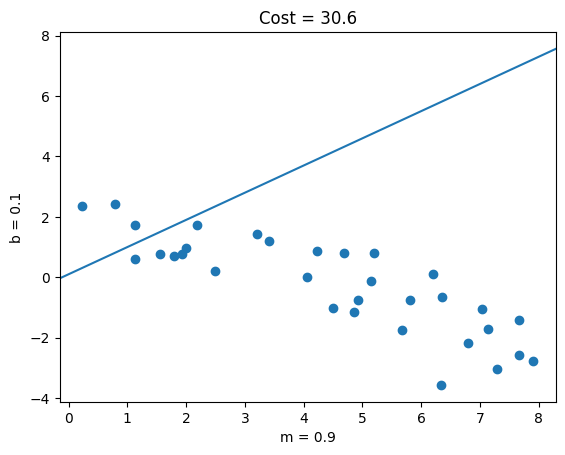

In [33]:
labeled_regression_plot(x[batch_indices], y[batch_indices], m, b, C, include_grad=False)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [34]:
C.backward()

In [35]:
m.grad

tensor([53.4475])

In [36]:
b.grad

tensor([8.5877])

The gradient of cost, $\nabla C$, is:

In [37]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ 8.5877],
        [53.4475]])

The vector of parameters $\boldsymbol{\theta}$ is:

In [38]:
theta = torch.tensor([[b, m]]).T
theta

tensor([[0.1000],
        [0.9000]])

**Step 4**: Gradient descent $$ \boldsymbol{\theta}' = \boldsymbol{\theta} - \alpha \nabla C $$

In [39]:
lr = 0.01

In [40]:
new_theta = theta - lr*gradient
new_theta

tensor([[0.0141],
        [0.3655]])

That's it! Let's update the `m` and `b` variables and confirm the correspond to a lower cost $C$:

In [41]:
b = new_theta[0]
m = new_theta[1]

In [42]:
C = mse(regression(x[batch_indices], m, b), y[batch_indices])
C

tensor(8.7904)

### Rinse and Repeat

In [43]:
b.requires_grad_()
_ = m.requires_grad_()

Instead of looping through epochs, we'll loop through rounds of SGD:

In [44]:
rounds = 100 # Use additional rounds (e.g., 1000) for better fit (or use a "fancy" optimizer)
for r in range(rounds):

    # This sampling step is slow; we'll cover much quicker batch sampling later:
    batch_indices = np.random.choice(n, size=batch_size, replace=False)

    yhat = regression(x[batch_indices], m, b) # Step 1
    C = mse(yhat, y[batch_indices]) # Step 2

    C.backward() # Step 3

    if r % 10 == 0:
        print('Step {}, cost {}, m grad {}, b grad {}'.format(r, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

    gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
    theta = torch.tensor([[b, m]]).T

    new_theta = theta - lr*gradient # Step 4

    b = new_theta[0].requires_grad_()
    m = new_theta[1].requires_grad_()

Step 0, cost 8.31, m grad 27, b grad 4.04
Step 10, cost 1.85, m grad 3.36, b grad -0.397
Step 20, cost 1.54, m grad -2.39, b grad -1.15
Step 30, cost 2.32, m grad 0.31, b grad -1.26
Step 40, cost 2.11, m grad 0.0417, b grad -0.813
Step 50, cost 1.15, m grad -1.25, b grad -0.779
Step 60, cost 1.24, m grad -0.288, b grad -0.487
Step 70, cost 1.66, m grad 0.536, b grad -0.412
Step 80, cost 1.56, m grad -0.425, b grad -0.644
Step 90, cost 1.52, m grad 1.38, b grad -0.266


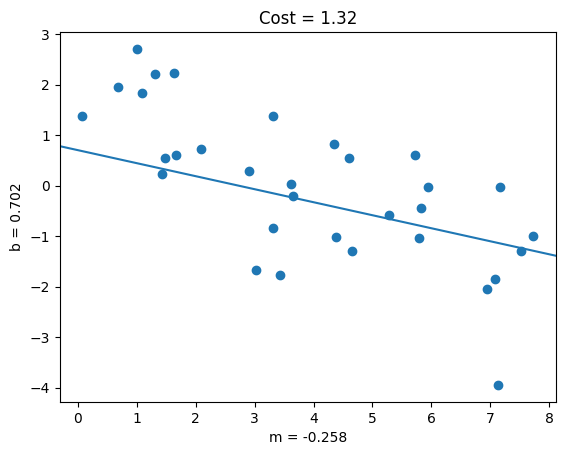

In [45]:
labeled_regression_plot(x[batch_indices], y[batch_indices], m, b, C, include_grad=False)

Since we have so many data points and we were sampling without replacement throughout this notebook, we can use our initial `indices` sample as model *validation data*:

In [46]:
validation_cost = mse(regression(x[indices], m, b), y[indices])

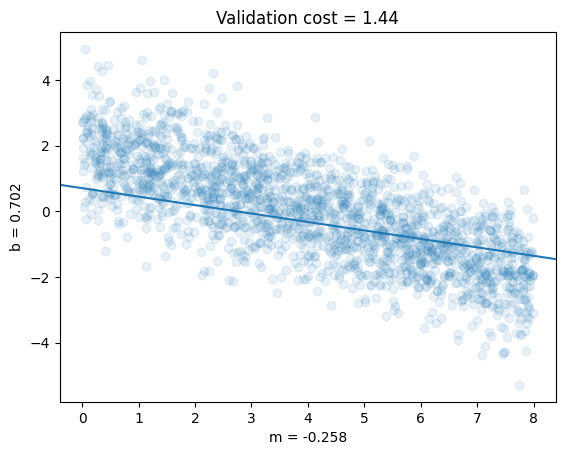

In [48]:
# Detach and convert tensors to numpy arrays for plotting:
x_np = x[indices].detach().numpy()
y_np = y[indices].detach().numpy()
m_val = m.detach()
b_val = b.detach()
validation_cost_val = validation_cost.detach()

fig, ax = plt.subplots()

ax.scatter(x_np, y_np, alpha=0.1)

x_min, x_max = ax.get_xlim()
y_min = regression(x_min, m_val, b_val)
y_max = regression(x_max, m_val, b_val)

plt.title('Validation cost = {}'.format('%.3g' % validation_cost_val.item()))
plt.ylabel('b = {}'.format('%.3g' % b_val.item()))
plt.xlabel('m = {}'.format('%.3g' % m_val.item()))

ax.set_xlim([x_min, x_max])
_ = ax.plot([x_min, x_max], [y_min, y_max], c='C100')

The model could fit the validation data better by being run for a thousand rounds instead of a hundred. However, using the batch-sampling method in this notebook is painfully slow. See the [*Learning Rate Scheduling* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/learning-rate-scheduling.ipynb), which builds on what we've done here to both more efficiently sample batches and refine the learning rate, thereby resulting in a much better-fitting model in a small fraction of the time.